In [ ]:
import polars as pl
from sklearn.model_selection import (
    GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, 
    cross_validate, RepeatedKFold
)
import matplotlib as plt

In [ ]:
householdspend = pl.read_csv("../Coursework Data/HouseholdSpend.csv")
demographics = pl.read_csv("../Coursework Data/DemoStats.csv")

# Dropping columns described in the Discord announcements
columns_to_drop = ["HSHNIAGG", "HSAGDISPIN", "HSAGDISCIN", 
                   "HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007"]
ifexisting_cols = [col for col in columns_to_drop if col in householdspend.columns]
householdspend.drop(ifexisting_cols)
householdspend.describe()

# Won't take out negatives according to plot below

statistic,CODE,GEO,HSBASHHD,HSHNIAGG,HSAGDISPIN,HSAGDISCIN,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""868970""","""868970""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,18.432629,2.2534e6,1.7170e6,1.2342e6,2.4008e6,2.1917e6,421335.834661,1.6065e6,388812.651163,278016.994627,111401.557243,109343.827301,76103.411113,271135.371662,87929.804561,45315.650319,70798.452452,34398.504565,3570.867859,70468.350013,25849.158365,33310.372386,115213.19111,48732.91062,209040.481816,67544.21004,4806.924846,112565.256385,15089.24985,9034.840695,388812.651163,303764.492909,89251.190609,88053.450315,…,236398.761036,118477.006209,114562.677761,14888.288571,8607.895903,91066.493288,188.957063,83.539013,105.41805,3725.371385,3469.552047,2092.59778,1376.954267,255.819338,1504.664209,116417.090618,3287.664753,10103.061471,12676.188385,18214.142317,100.530695,63415.559732,2639.560863,4612.181943,1368.200459,379.01064,989.189819,34736.610626,5995.306708,2258.469958,915.416319,23038.220756,71.1409,1322.434304,831.592595,490.84171,1135.621681
"""std""",null,null,69.379951,8.2787e6,6.3276e6,4.6340e6,9.1329e6,8.0562e6,1.5969e6,5.9255e6,1.3661e6,1.0471e6,420881.63654,429642.774397,290959.592849,1.0751e6,327376.60947,163377.943862,249311.269506,114999.916794,14386.745375,264786.580294,94955.831503,127397.296924,431645.982804,206454.726959,1.2713e6,341440.420828,40531.631801,898861.389623,51492.602769,35858.838458,1.3661e6,1.0270e6,292325.224526,287942.333453,…,990960.632583,507452.95803,494184.487741,58848.760548,45895.371562,398856.15598,794.022208,358.55285,497.256289,14112.764792,13213.369738,8173.498909,5705.767025,1422.161917,5673.303299,486744.921092,14400.182837,39378.141535,60281.31644,71889.568827,615.785308,284702.777168,13567.714202,14917.235034,5725.037991,2091.296014,3882.026395,101629.434794,19414.670337,7613.821326,5037.673958,71509.135272,257.018871,6638.799848,5076.885882,2097.649493,4203.801021
"""min""","""A0A0A0""","""FSALDU""",0.0,0.0,0.0,0.0,-24249.492537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4599e7,0.0,0.0,-1.6806e7,-26676.98553,-204380.698719,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
# counting negatives
numeric_cols = householdspend.select(pl.col(pl.Float64))
negative_counts = numeric_cols.select(pl.col('*').lt(0).sum()).row(0)
total_negatives = sum(negative_counts)

print(f"Negative counts per numeric column: {dict(zip(numeric_cols.columns, negative_counts))}")
print(f"Total negative values across numeric columns: {total_negatives}")

Negative counts per numeric column: {'HSHNIAGG': 0, 'HSAGDISPIN': 0, 'HSAGDISCIN': 0, 'HSTT001': 28, 'HSTE001': 0, 'HSTX001': 0, 'HSTC001': 0, 'HSSH001S': 0, 'HSFD001S': 0, 'HSHO001S': 0, 'HSHC001S': 0, 'HSHF001S': 0, 'HSTR001S': 0, 'HSRE001S': 0, 'HSPC001S': 0, 'HSCL001S': 0, 'HSED002S': 0, 'HSRO001S': 0, 'HSTA001S': 0, 'HSGC001S': 0, 'HSME001S': 0, 'HSEP001S': 0, 'HSMG001S': 0, 'HSTE001ZBS': 163557, 'HSWH002S': 0, 'HSWH028S': 0, 'HSWH040S': 255858, 'HSWH041S': 15436, 'HSWH042S': 19205, 'HSSH001': 0, 'HSSH002': 0, 'HSSH003': 0, 'HSSH004': 0, 'HSSH053': 0, 'HSSH054': 0, 'HSSH005': 0, 'HSSH006': 0, 'HSSH007': 0, 'HSSH010': 0, 'HSSH011': 0, 'HSSH014': 0, 'HSSH013': 0, 'HSSH015': 0, 'HSSH016': 0, 'HSSH017': 0, 'HSSH018': 0, 'HSSH019': 0, 'HSSH021': 0, 'HSSH020': 0, 'HSSH022': 0, 'HSSH012': 0, 'HSRM002A': 0, 'HSRM002B': 0, 'HSRM003A': 0, 'HSRM003B': 0, 'HSRM004': 0, 'HSRM005': 0, 'HSRM006': 0, 'HSRM007': 0, 'HSRM008M': 0, 'HSRM009A': 0, 'HSRM009B': 0, 'HSRM010': 0, 'HSRM011': 0, 'HSRM012':

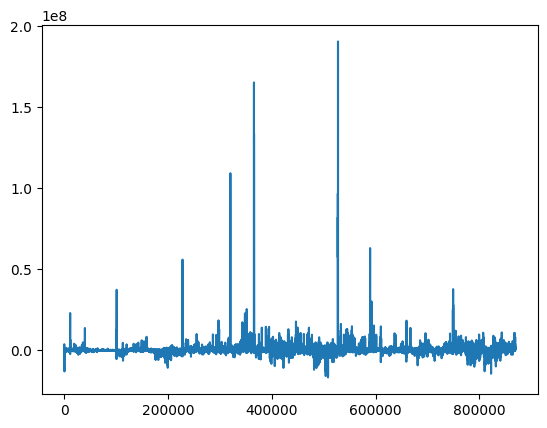

In [ ]:
# Showing plot
plt.plot(householdspend["HSWH040S"].to_numpy())
plt.show()

In [4]:
demographics.describe()

statistic,CODE,GEO,ECYASQKM,ECYALSQKM,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,…,ECYRIMINDI,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""868970""","""868970""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,0.0,0.0,46.684199,18.432629,45.881762,41.254934,39.613594,37.819792,37.323999,40.336732,38.832472,37.263988,36.746572,3.072744,24.49923,12.76093,12.051364,12.740845,24.633679,46.684199,2.181318,2.390635,2.498651,2.672259,3.213171,3.308621,3.406466,3.258362,3.117668,2.858167,2.776588,2.859335,3.10898,2.80384,…,0.477122,0.005692,0.038764,0.008754,0.00028,0.007272,0.005106,0.002166,45.881762,31.717238,11.757474,4.721479,2.368195,1.391643,1.640656,1.635501,2.407051,45.881762,31.717238,11.757474,1.066154,2.036562,2.230265,5.299374,1.125119,2.407051,45.881762,14.168175,7.448384,24.265204,45.881762,40.528679,7.761493,32.767185,5.353084,0.85628,4.496803
"""std""",null,null,0.0,0.0,174.837877,69.379951,171.817976,152.539099,145.876662,139.320601,137.611402,149.038058,143.038376,137.181937,135.319262,12.468123,87.647782,50.126862,47.828225,49.02113,89.352097,174.837877,9.518254,10.400337,10.705186,10.30089,10.888878,10.894537,11.699239,11.371185,11.099312,10.485757,10.544898,11.657788,13.69638,12.729886,…,2.516032,0.123928,0.364373,0.142995,0.02439,0.118581,0.094428,0.057987,171.817976,149.721097,32.868441,14.28478,7.28958,4.605282,5.813031,5.761745,10.479555,171.817976,149.721097,32.868441,3.400699,6.112712,6.550715,14.905824,3.936661,10.479555,171.817976,40.185434,24.588753,131.818196,171.817976,163.866165,34.782061,130.449848,17.893635,3.211073,15.020402
"""min""","""A0A0A0""","""FSALDU""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",null,null,0.0,0.0,8.0,3.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,0.0,4.0,2.0,2.0,2.0,4.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,